# Пособие по Augmentation

## Использование LookGenerator.config.config

In [101]:
import os
import numpy as np

from LookGenerator.config.config import DatasetConfig

Config = DatasetConfig(os.environ)
None

In [102]:
Config.DATASET_DIR

'C://Users//zanoo//PycharmProjects//zalando-hd-resized//train'

## Класс датасет для работы с файлами

In [103]:
from torchvision.transforms import ToTensor
import torch
import numpy as np
from typing import Tuple
from multipledispatch import dispatch

from PIL import Image
from torch.utils.data import Dataset

In [150]:
class ImageDataset(Dataset):
    """ Dataset of images """

    def __init__(self, root_dir: str, dir_name: str):
        """
        Args:
            img_dir (string) : path to images
        """

        super().__init__()

        self.root = os.path.join(root_dir, dir_name)

        names_of_files =  os.listdir(self.root)

        self._files_list = [name.split('.')[0] for name in names_of_files]
        self._extensions_list = [name.split('.')[1] for name in names_of_files]

    @dispatch(int)
    def __getitem__(self, idx: int) -> np.array:
        """
        Args: idx: The index of data sample
        Returns:
            Return np.array that represent image
        """

        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_ = np.array(Image.open(os.path.join(self.root,
                                     self._files_list[idx] + "." + self._extensions_list[idx])))
        return input_

    @dispatch(str)
    def __getitem__(self, name: str)-> np.array:
        input_ = np.array(Image.open(os.path.join(self.root,
                                     name + "." + self._extensions_list[self.__get_files_list__().index(name)])))
        return input_

    @dispatch(str, int, int)
    def __getitem__(self, name: str, width: int, height: int):
        return np.array(ToPILImage()(self.__getitem__(name)).resize((width, height)))

    @dispatch(int, int, int)
    def __getitem__(self, idx: int, width: int, height: int):
        return np.array(ToPILImage()(self.__getitem__(idx)).resize((width, height)))

    def __get_name__(self, idx):
        """
        Args: The index of data sample
        Return: name of file and its extension
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        name_ = self._files_list[idx]
        extension_ = self._extensions_list[idx]

        return name_, extension_

    def __get_files_list__(self):
        return self._files_list

    def __len__(self):
        return len(self._files_list)


In [151]:
class PersonDataset(Dataset):
    def __init__(self, root_dir: str, dir_name_person: str, dir_name_mask: str):
        self.person_dataset = ImageDataset(root_dir, dir_name_person)
        self.mask_dataset = ImageDataset(root_dir, dir_name_mask)

        self.dir_name_person = dir_name_person
        self.dir_name_mask = dir_name_mask

        self._files_list = [file for file in self.mask_dataset.__get_files_list__() if file in self.person_dataset.__get_files_list__()]

    def __get_files_list__(self):
        return self._files_list

    def __len__(self):
        return len(self.__get_files_list__())

    def __getitem__(self,  idx) -> Tuple[np.array, np.array]:
        return self.person_dataset.__getitem__(self.__get_files_list__()[idx]), \
               self.mask_dataset.__getitem__(self.__get_files_list__()[idx])


## Импорт изображений человека, маски и фона

In [152]:
dataset_of_persons = PersonDataset(Config.DATASET_DIR, "image", "image-parse-v3")
dataset_of_backgrounds = ImageDataset(Config.HOUSE_ROOM_DATASET, "Bedroom")

In [153]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage

In [245]:
import math
import matplotlib.pyplot as plt

to_tensor = ToTensor()

def print_triple(*data_of_images):
    fig = plt.figure(figsize=(20, 14))
    for i, data_of_image in enumerate(data_of_images):
        fig.add_subplot( math.ceil( len(data_of_images) / 4) +1, 4, i +1 )

        plt.imshow(data_of_image)

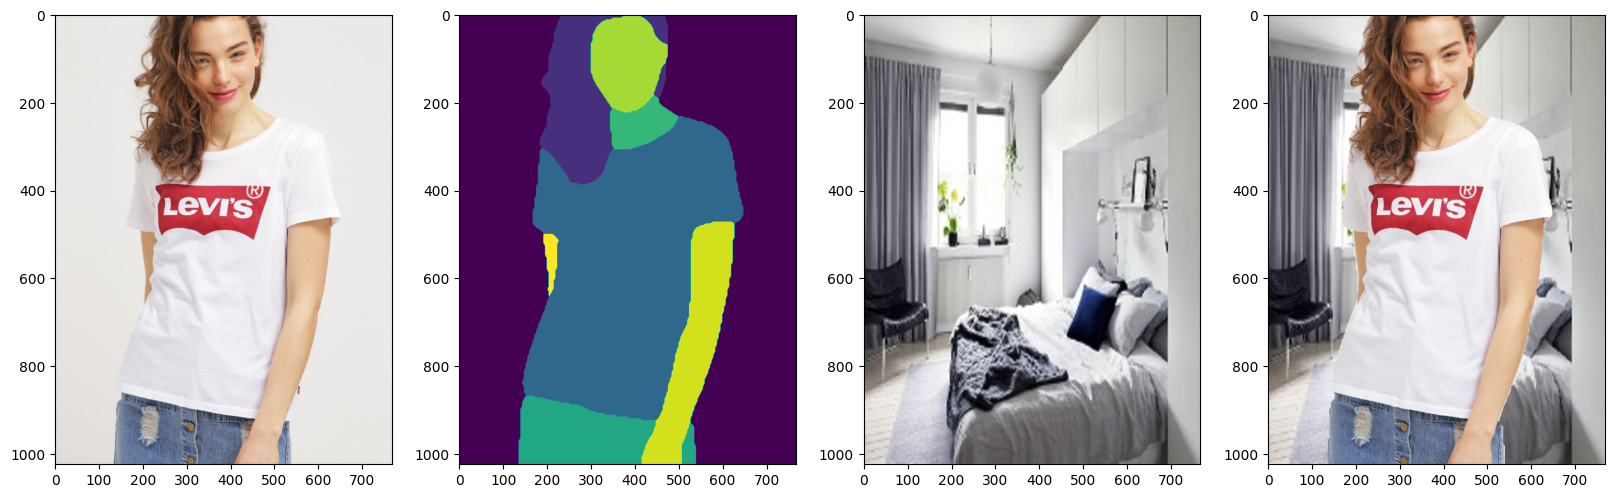

In [246]:
image = dataset_of_persons.__getitem__(0)
background = dataset_of_backgrounds.__getitem__(100, 768, 1024)

print_triple(image[0], image[1], background, result)

# Аугментация

In [237]:
mask = image[1] == 0

In [238]:
result = np.copy(image[0])

In [239]:
image[0].shape

(1024, 768, 3)

In [240]:
result[mask] = background[mask]

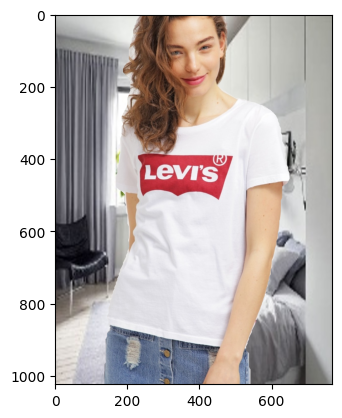

In [241]:
plt.imshow(result)

In [215]:
np.put(result, image[1] == 0, background)

In [217]:
image[0]

array([[[232, 231, 227],
        [232, 231, 227],
        [232, 231, 227],
        ...,
        [234, 233, 231],
        [234, 233, 231],
        [234, 233, 231]],

       [[232, 231, 227],
        [232, 231, 227],
        [232, 231, 227],
        ...,
        [234, 233, 231],
        [234, 233, 231],
        [234, 233, 231]],

       [[232, 231, 227],
        [232, 231, 227],
        [232, 231, 227],
        ...,
        [234, 233, 231],
        [234, 233, 231],
        [234, 233, 231]],

       ...,

       [[224, 221, 216],
        [224, 221, 216],
        [224, 221, 216],
        ...,
        [233, 229, 226],
        [232, 228, 225],
        [232, 228, 225]],

       [[224, 221, 216],
        [224, 221, 216],
        [224, 221, 216],
        ...,
        [233, 229, 226],
        [232, 228, 225],
        [232, 228, 225]],

       [[224, 221, 216],
        [224, 221, 216],
        [224, 221, 216],
        ...,
        [233, 229, 226],
        [232, 228, 225],
        [232, 228, 225]]

In [216]:
result[0]

array([[175, 170, 227],
       [232, 231, 227],
       [232, 231, 227],
       ...,
       [234, 233, 231],
       [234, 233, 231],
       [234, 233, 231]], dtype=uint8)

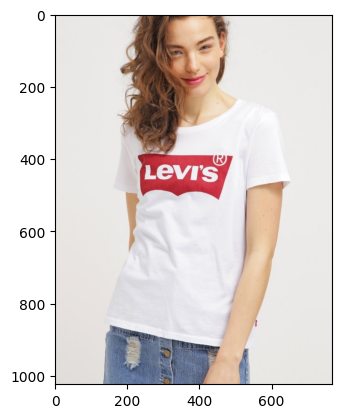

In [219]:
plt.imshow(result)

In [193]:
def compose(image, mask, background, mask_pixel = [0, 0, 0]):
    result = image.copy

    np.putmask(result, result == [0, 0, 0], background)

    return result

In [194]:
res = compose(image[0], image[1], background)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
def augmentation(person_dataset: dataset_of_persons, background_dataset: dataset_of_backgrounds):
    for person in person_dataset:
        for background in background_dataset:
            pass
            #compose
            #save